In [1]:
from pycromanager import Bridge, Acquisition, multi_d_acquisition_events
import numpy as np
import copy
import matplotlib.pyplot as plt
from image_utils import *
from skimage.filters import threshold_mean

In [3]:
def switch_objective(core, objective='20x'):
    # check current objective and compare to taget
    # move stage first
    # switch objective
    # set corresponding condensor position
    # set default led intensity
    return core

In [4]:
def config_autofocus(studio, search_range=50, crop_factor=0.25):
    autofocus_manager = studio.get_autofocus_manager()
    autofocus_manager.set_autofocus_method_by_name('OughtaFocus')
    current_autofocus = autofocus_manager.get_autofocus_method()
    current_autofocus.set_property_value('SearchRange_um', str(search_range))
    current_autofocus.set_property_value('CropFactor', str(crop_factor))
    return studio

In [5]:
def snap_image(core, color=True):
    core.snap_image()
    tagged_image = core.get_tagged_image()
    if color:
        pixels = np.reshape(tagged_image.pix,
                            newshape=[tagged_image.tags['Height'], tagged_image.tags['Width'], 4])
    else:
        pixels = np.reshape(tagged_image.pix,
                            newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])
    img_data = copy.deepcopy(pixels)
    return img_data

In [6]:
bridge = Bridge()
core = bridge.get_core()
studio = bridge.get_studio()

In [9]:
img = snap_image(core, False)

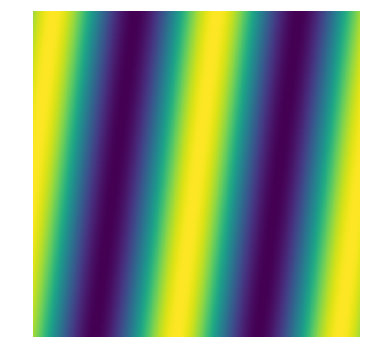

In [10]:
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [14]:
config_autofocus(studio)

In [15]:
with Acquisition(directory='test', name='exp_2-1_1024_pos_'+str(0)) as acq:
    events = multi_d_acquisition_events(z_start=-20, z_end=20, z_step=5)
    acq.acquire(events)

In [7]:
autofocus_manager.get_all_autofocus_methods()

In [11]:
autofocus_manager.set_autofocus_method_by_name('OughtaFocus')

In [12]:
current_autofocus = autofocus_manager.get_autofocus_method()

In [16]:
current_autofocus.set_property_value('SearchRange_um', '50')

In [17]:
current_autofocus.get_property_value('SearchRange_um')

'50'

In [61]:
config = {
    "low_mag_pixel_size": 1,
    "high_mag_pixel_size": 0.1,
    "high_shg_z_offset": 300,
    "high_shg_xy_offset": (100, 150),
    "low_high_z_offset": 50,
    "low_high_xy_offset": (10, 15),
    "low_box": ((0, 0), (20480, 10240)),
    "low_led_intensity": 1.45,
    "high_led_instensity": 0.3,
    "camera_resolution": (1024, 1024),
}

In [144]:
class Grid():
    def __init__(self, config):
        self.config = config
    
    def generate_low_grid(self, overlap=0.1):
        config = self.config
        resolution = config['camera_resolution']
        start = config['low_box'][0]
        end = config['low_box'][1]
        field_size_x = resolution[0] * config['low_mag_pixel_size'] * (1-overlap)
        field_size_y = resolution[0] * config['low_mag_pixel_size'] * (1-overlap)
        columns = int(np.ceil((end[0] - start[0]) / field_size_x))
        rows = int(np.ceil((end[1] - start[1]) / field_size_y))
        grid = []
        for j in range(rows):
            for i in range(columns):
                grid.append((start[0] + i * field_size_x, start[1] + j * field_size_y)) # (x, y)
        return grid
    
    def bounding_image(self, image):
        PIL.Image.MAX_IMAGE_PIXELS = None        
        config = self.config
        img_g = color.rgb2gray(img)
        img_t = transform.rescale(img_g, 0.1, anti_aliasing=None, order=0)
        thresh = threshold_mean(img_t)
        img_d = 1 - (img_t > thresh)
        imgh = np.sum(img_d, axis = 1)
        imgw = np.sum(img_d, axis = 0)
        imgh_m = np.mean(imgh)
        imgw_m = np.mean(imgw)
        box_s_x = min(np.argwhere(imgw>imgw_m*0.2))[0] * 10
        box_s_y = min(np.argwhere(imgh>imgh_m*0.2))[0] * 10
        box_e_x = max(np.argwhere(imgw>imgw_m*0.2))[0] * 10
        box_e_y = max(np.argwhere(imgh>imgh_m*0.2))[0] * 10
        start = config['low_box'][0]
        low_box_bounded = ((start[0] + box_s_x * config['low_mag_pixel_size'], start[1] + box_s_y * config['low_mag_pixel_size']),
                          (start[0] + box_e_x * config['low_mag_pixel_size'], start[1] + box_e_y * config['low_mag_pixel_size']))
        fig, ax = plt.subplots(1)
        ax.imshow(img_t, cmap='gray')
        rect = patches.Rectangle((int(box_s_x/10),int(box_s_y/10)), int((box_e_x-box_s_x)/10), int((box_e_y-box_s_y)/10), linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        return low_box_bounded
    
    def generate_high_grid(self, low_box_bounded, overlap=0.1):
        config = self.config
        resolution = config['camera_resolution']
        start = low_box_bounded[0]
        end = low_box_bounded[1]
        field_size_x = resolution[0] * config['high_mag_pixel_size'] * (1-overlap)
        field_size_y = resolution[0] * config['high_mag_pixel_size'] * (1-overlap)
        columns = int(np.ceil((end[0] - start[0]) / field_size_x))
        rows = int(np.ceil((end[1] - start[1]) / field_size_y))
        grid = []
        for j in range(rows):
            for i in range(columns):
                grid.append((start[0] + i * field_size_x, start[1] + j * field_size_y)) # (x, y)
        return grid
    

In [145]:
grider = Grid(config)

In [146]:
len(grider.generate_low_grid(overlap=0.05))

242

In [148]:
grider.generate_high_grid(box, overlap=0.05)[-1]

(18607.68, 13156.32)

In [136]:
from skimage import io, transform, color
from PIL import Image
import PIL
from skimage.filters import threshold_mean
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [84]:
img = io.imread('BIC14011b.jpg')

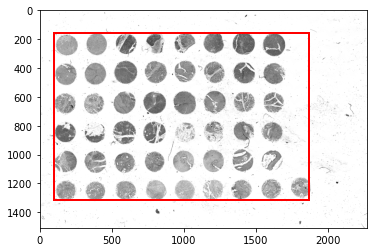

In [143]:
box = grider.bounding_image(img)

In [ ]:
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [1]:
import glob, os, shutil

In [2]:
lsm_images = glob.glob('data/slides/mp/PA-961e-lsm-256/*')

In [3]:
for lsm_img in lsm_images:
    new_name = lsm_img.replace('elsm', 'e-lsm')
    os.rename(lsm_img, new_name)